**Load data**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

USE_MIXED = True
USE_PRESSURE_TEMP = False
USE_SPECIFIC_CLOUDS = True
LOW_VIS_FRAC = True
low_vis_frac_train = 0.05
low_vis_frac_test = 0.05
low_vis_threshold = 10000 #50000
cloud_types = [0,1,2] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # % of max
dnn_batch_size = 64

TEST_FRACTION = False

if USE_MIXED:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_mixed.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_mixed.dat', 'fog_data_ir_water.dat']
else:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])


# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)


if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]


X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


if not TEST_FRACTION:
    # First split: Separate out a test set (5% of the original dataset)
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=(1/20))



if LOW_VIS_FRAC:
    if not TEST_FRACTION:
        low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]
    else:
        low_vis_i = np.where(target_scaler.inverse_transform(y_scaled) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_scaled) >= low_vis_threshold)[0]


    n_high_vis = int(len(low_vis_i) / low_vis_frac_train * (1 - low_vis_frac_train))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac_train * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    if not TEST_FRACTION:
        X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
        y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])
    else:
        X_temp = np.vstack([X_scaled[low_vis_i], X_scaled[r_high_vis_i]])
        y_temp = np.vstack([y_scaled[low_vis_i], y_scaled[r_high_vis_i]])


if TEST_FRACTION:
    X_temp, X_test, y_temp, y_test = train_test_split(X_temp, y_temp, test_size=(1/19))
  

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold, 1, 0)
y_val_label = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold, 1, 0)
y_test_label = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)


2024-03-07 09:43:31.794795: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 09:43:31.829747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 09:43:31.829771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 09:43:31.830612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 09:43:31.836676: I tensorflow/core/platform/cpu_feature_guar

real frac: 0.05480018832660399
n_low_vis: 3137. n_high_vis: 62745


2024-03-07 09:43:41.548265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 09:43:41.580399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 09:43:41.582604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3460
           1       0.57      0.12      0.20       189

    accuracy                           0.95      3649
   macro avg       0.76      0.56      0.59      3649
weighted avg       0.93      0.95      0.93      3649



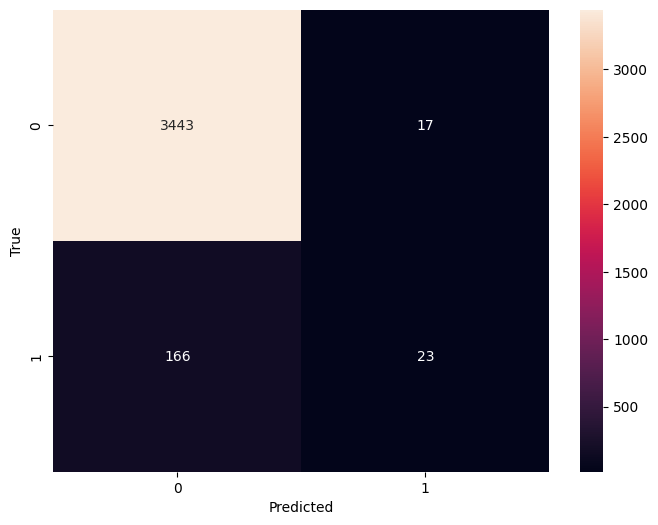

40
189


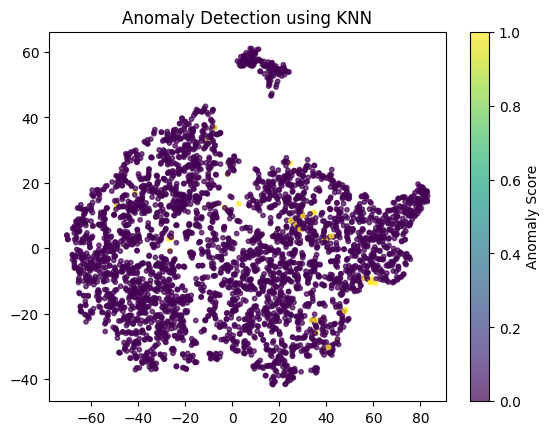

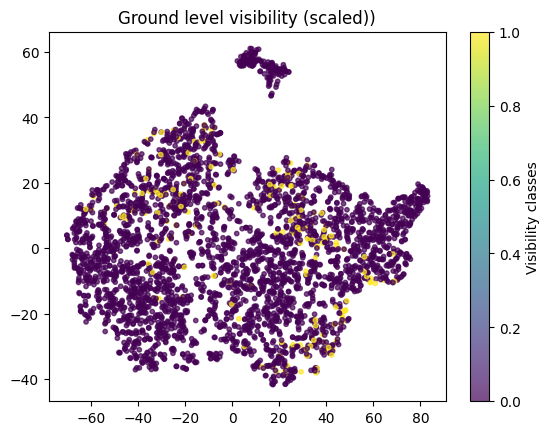

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_noisy, y_train_label)

# Predict whether each data point is an anomaly (0 for anomalies, 1 for normal data)
predictions = clf.predict(X_test_noisy)

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
print(classification_report(y_test_label, predictions))
cm = confusion_matrix(y_test_label, predictions)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Assuming X_test_noisy is your noisy test data
# Shape of X_test_noisy: (number of samples, number of features)

# Initialize t-SNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2 dimensions
X_tsne = tsne.fit_transform(X_test_noisy)

print(np.sum(predictions))
print(np.sum(y_test_label))

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predictions, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Detection using KNN")
plt.show()

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_label, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="Visibility classes")
plt.title("Ground level visibility (scaled))")
plt.show()

0.04278305963699222
0.18204579624069456
0.18204579624069456
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2215
           1       0.00      0.00      0.00        99

    accuracy                           0.91      2314
   macro avg       0.48      0.47      0.48      2314
weighted avg       0.91      0.91      0.91      2314



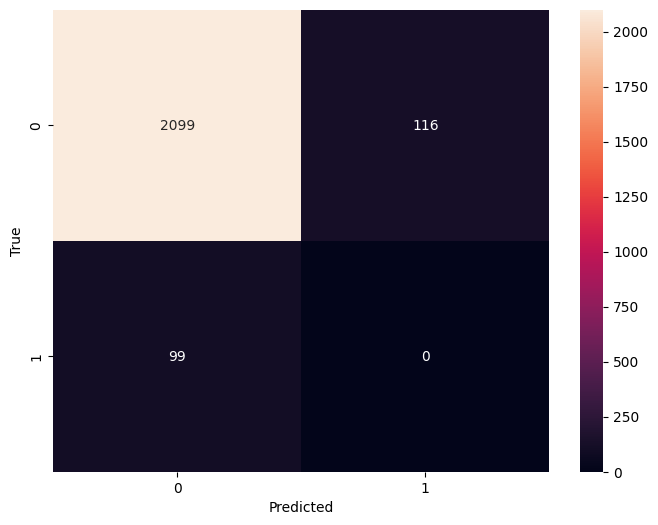

In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Create an Isolation Forest model
fog_frac = np.sum(y_test_label) / len(y_test_label)
print(fog_frac) 

isolation_forest = IsolationForest(contamination=fog_frac)  # Set contamination to your expected proportion of anomalies

# Train the model
isolation_forest.fit(X_train_noisy, y_train_label)  # Including labels during training

# Predict outliers/anomalies
anomaly_scores = isolation_forest.decision_function(X_test_noisy)

# The anomaly_scores represent the anomaly score of each instance
# You can use these scores to determine anomalies based on a threshold
# For example, you can set a threshold and label instances with scores below the threshold as anomalies
threshold = np.percentile(anomaly_scores, 95)  # Set threshold based on a percentile of anomaly scores

print(threshold)

predicted_labels = np.where(anomaly_scores < threshold, 0, 1)  # Anomalies marked as 1, normal instances marked as -1

print(threshold)
# Evaluate the model
# Assuming you have ground truth labels for evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test_label, predicted_labels))
cm = confusion_matrix(y_test_label, predicted_labels)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, average_precision_score



# Train One-Class SVM
ocsvm = OneClassSVM(gamma='auto')
#ocsvm.fit(X_train_noisy[np.where(y_train_label == 0)[0]])  # Fit on high vis pixels only
ocsvm.fit(X_train_noisy)  # Fit on all pixels


# Predict anomaly scores
anomaly_scores = ocsvm.decision_function(X_test_noisy)


thresholds = np.arange(-2000, 1000, 50)
avg_precisions = np.zeros(thresholds.shape)
accuracies = np.zeros(thresholds.shape)
#t = 0
#predicted_labels = (anomaly_scores < t).astype(int)
#print(average_precision_score(y_test_label, predicted_labels))


for i, t in enumerate(thresholds):
    predicted_labels = (anomaly_scores < t).astype(int)
    avg_precisions[i] = average_precision_score(y_test_label, predicted_labels)
    accuracies[i] = accuracy_score(y_test_label, predicted_labels)




# print(classification_report(y_test_label, predicted_labels))
# cm = confusion_matrix(y_test_label, predicted_labels)
# plt.figure(figsize=(8,6)) 
# sn.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()


In [3]:
print(f'Accurcy: {np.max(accuracies)} at t = {thresholds[np.argmax(accuracies)]}')
print(f'Avg Precision: {np.max(avg_precisions)} at t = {thresholds[np.argmax(avg_precisions)]}')

Accurcy: 0.8432 at t = -2000
Avg Precision: 0.31060546158748836 at t = -1250


In [ ]:
# Initialize and fit the One-Class SVM model
clf = OneClassSVM(nu=0.05, kernel="rbf")  # Adjust the nu parameter as needed
clf.fit()

# Predict whether each data point is an anomaly (-1 for anomalies, 1 for normal data)
predictions = clf.predict(data)

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Detection using One-Class SVM")
plt.show()

# Identify anomalies (outliers)
anomalies_indices = np.where(predictions == -1)[0]
print("Detected anomalies:", anomalies_indices)

In [21]:
import numpy as np
import tensorflow as tf
from keras import layers, models

# Assume X_train, y_train, X_test, and y_test are numpy arrays containing the training and testing data
# X_train: Normal data samples
# y_train: Labels for normal data samples (0 for normal, 1 for anomaly)
# X_test: Normal and anomalous data samples for testing
# y_test: Labels for testing data samples

# Define autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32

input_data = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_data)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_noisy, y_train_label, epochs=50, batch_size=128, validation_split=0.2)

# Define reconstruction error threshold
reconstruction_errors = np.mean(np.square(X_test_noisy - autoencoder.predict(X_test_noisy)), axis=1)
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

# Predict anomalies based on the threshold
y_pred = np.where(reconstruction_errors > threshold, 1, 0)

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_label, y_pred)
precision = precision_score(y_test_label, y_pred)
recall = recall_score(y_test_label, y_pred)
f1 = f1_score(y_test_label, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 1/50


282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1935 - val_loss: 0.0937
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0928 - val_loss: 0.0771
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0804 - val_loss: 0.0750
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0801 - val_loss: 0.0739
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0779 - val_loss: 0.0725
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0785 - val_loss: 0.0720
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0760 - val_loss: 0.0716
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0750 - val_loss: 0.0709
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0767 - val_loss: 0.0708
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0744 - val_loss: 0.0709
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0750 - val_loss: 0.0700
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Epoch 1/60


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


W0000 00:00:1709563243.831410 1026773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


287/287 - 10s - 35ms/step - accuracy: 0.7862 - loss: 0.5845 - val_accuracy: 0.8163 - val_loss: 0.4920
Epoch 2/60
287/287 - 1s - 3ms/step - accuracy: 0.8216 - loss: 0.4556 - val_accuracy: 0.8291 - val_loss: 0.4411
Epoch 3/60
287/287 - 1s - 3ms/step - accuracy: 0.8265 - loss: 0.4162 - val_accuracy: 0.8222 - val_loss: 0.4087
Epoch 4/60
287/287 - 1s - 3ms/step - accuracy: 0.8304 - loss: 0.3933 - val_accuracy: 0.8261 - val_loss: 0.3915
Epoch 5/60
287/287 - 1s - 3ms/step - accuracy: 0.8303 - loss: 0.3809 - val_accuracy: 0.8222 - val_loss: 0.3836
Epoch 6/60
287/287 - 1s - 3ms/step - accuracy: 0.8344 - loss: 0.3669 - val_accuracy: 0.8350 - val_loss: 0.3721
Epoch 7/60
287/287 - 1s - 2ms/step - accuracy: 0.8342 - loss: 0.3587 - val_accuracy: 0.8251 - val_loss: 0.3677
Epoch 8/60
287/287 - 1s - 2ms/step - accuracy: 0.8349 - loss: 0.3533 - val_accuracy: 0.8251 - val_loss: 0.3653
Epoch 9/60
287/287 - 1s - 3ms/step - accuracy: 0.8365 - loss: 0.3483 - val_accuracy: 0.8330 - val_loss: 0.3576
Epoch 10/6

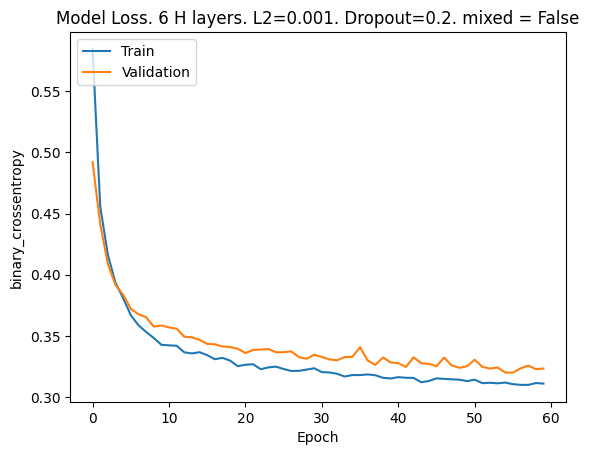

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.59      0.77      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.84      0.80      2500
weighted avg       0.90      0.88      0.89      2500



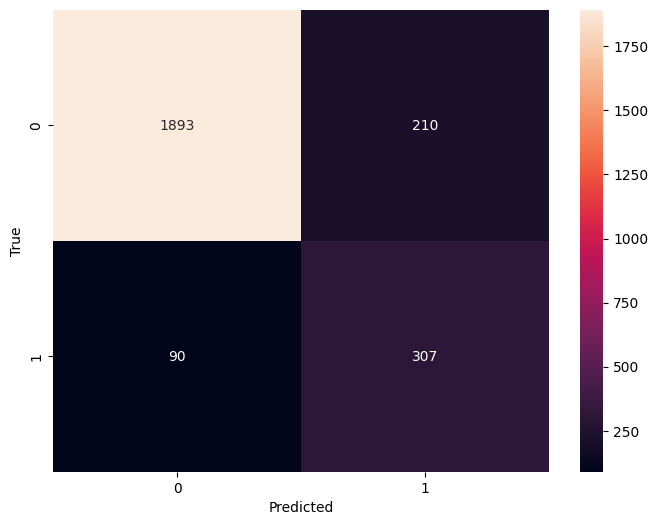

In [81]:
from keras import layers
from keras import regularizers
from keras.layers import Attention
from sklearn.metrics import classification_report


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# for t in thresholds:
#     y_pred_label = (y_pred > t ).astype(int)
#     plt.figure(figsize=(8,6)) 
#     sn.heatmap(confusion_matrix(y_test_label, y_pred_label), annot=True, fmt='d')
#     plt.title(f't = {t}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2103
           1       0.59      0.75      0.66       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.79      2500
weighted avg       0.89      0.88      0.88      2500



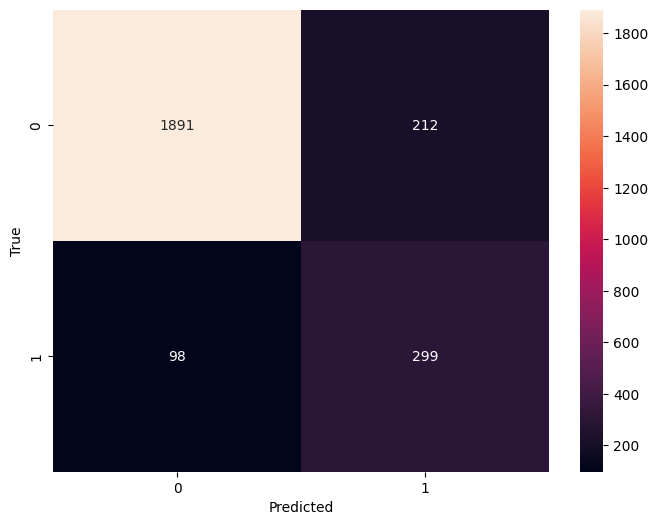

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.59      0.77      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.90      0.88      0.88      2500



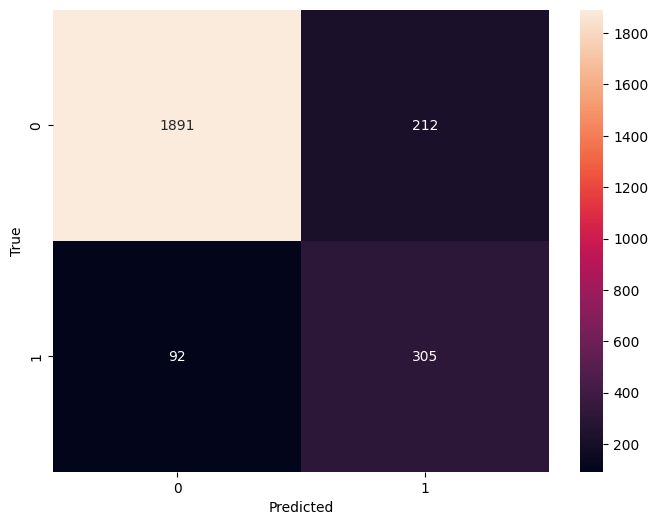

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

rf_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

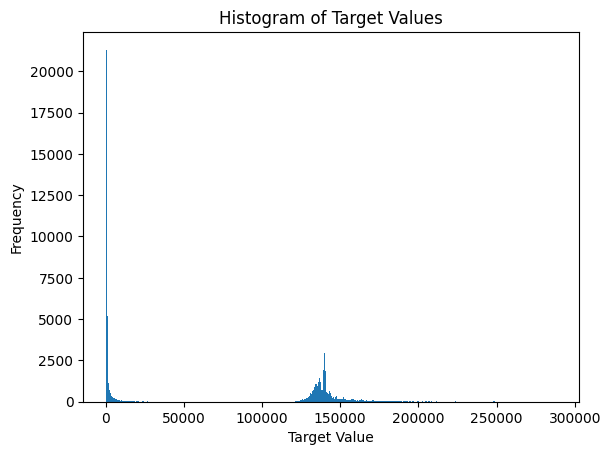

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your target values are in a NumPy array called 'target_values'
plt.hist(y, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Random Forest Regressor

Mean Squared Error: 0.6128729113369529


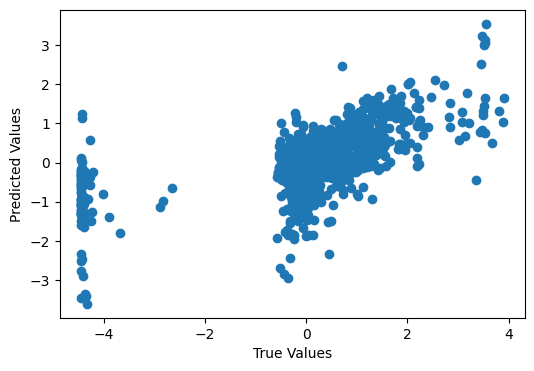

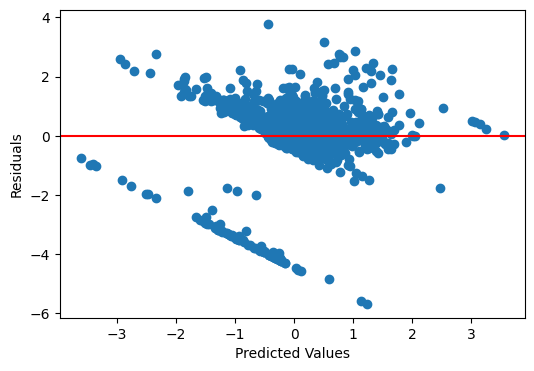

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_noisy, y_train.ravel())

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

Mean Squared Error: 0.6247968936755467


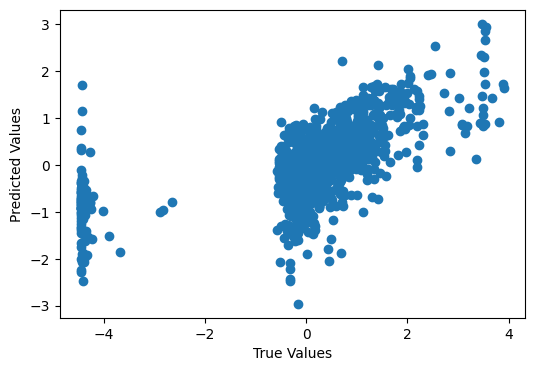

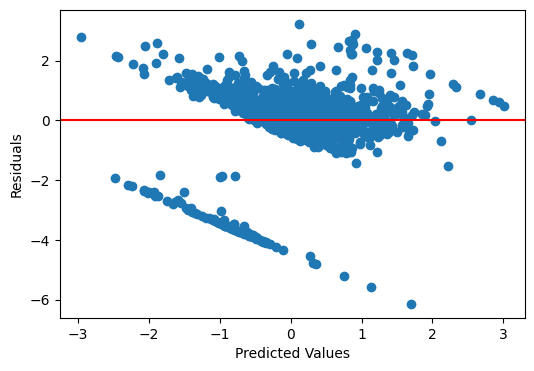

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN Regression

In [ ]:
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data, epochs = 150, validation_data=(X_val_noisy, y_val))


y_pred = ff_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Tabnet

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73769 | val_0_auc: 0.78765 |  0:00:00s
epoch 1  | loss: 0.48379 | val_0_auc: 0.84316 |  0:00:01s
epoch 2  | loss: 0.44894 | val_0_auc: 0.8545  |  0:00:01s
epoch 3  | loss: 0.42888 | val_0_auc: 0.86877 |  0:00:02s
epoch 4  | loss: 0.41115 | val_0_auc: 0.87171 |  0:00:02s
epoch 5  | loss: 0.39886 | val_0_auc: 0.88586 |  0:00:03s
epoch 6  | loss: 0.39222 | val_0_auc: 0.87935 |  0:00:03s
epoch 7  | loss: 0.38672 | val_0_auc: 0.8826  |  0:00:04s
epoch 8  | loss: 0.38543 | val_0_auc: 0.89496 |  0:00:04s
epoch 9  | loss: 0.37492 | val_0_auc: 0.89691 |  0:00:05s
epoch 10 | loss: 0.36736 | val_0_auc: 0.90099 |  0:00:05s
epoch 11 | loss: 0.36501 | val_0_auc: 0.89947 |  0:00:06s
epoch 12 | loss: 0.36368 | val_0_auc: 0.90034 |  0:00:06s
epoch 13 | loss: 0.3585  | val_0_auc: 0.90241 |  0:00:07s
epoch 14 | loss: 0.35671 | val_0_auc: 0.89732 |  0:00:08s
epoch 15 | loss: 0.35331 | val_0_auc: 0.90791 |  0:00:08s
epoch 16 | loss: 0.3494  | val_0_auc: 0.90893 |  0:00:09s
epoch 17 | los

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.60      0.75      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.89      0.88      0.89      2500



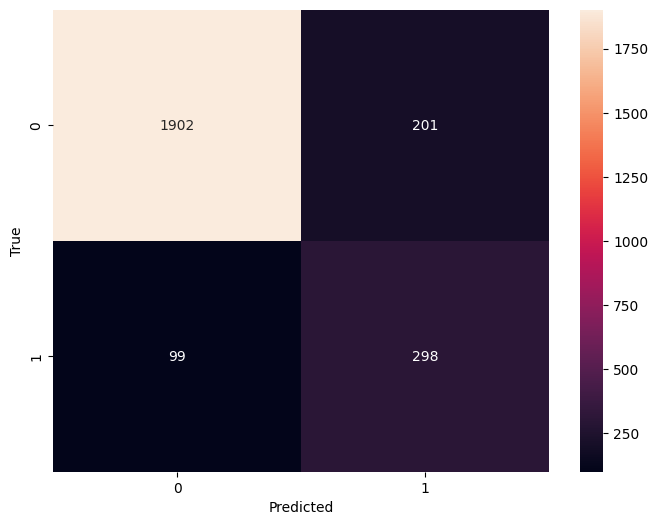

In [84]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier()

clf.fit(
  X_train_noisy, y_train_label.ravel(), max_epochs=125,
  eval_set=[(X_val_noisy, y_val_label.ravel())]
)
preds = clf.predict(X_test_noisy)

print(classification_report(y_test_label, preds))
cm = confusion_matrix(y_test_label, preds)

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN Classification

In [ ]:
from keras import layers
from keras import regularizers
from keras.layers import Attention

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 10, validation_data=(X_val_noisy, y_val_label))


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for t in thresholds:
    y_pred_label = (y_pred > t ).astype(int)
    print(f'threshold: {t}')
    print(accuracy_score(y_test_label, y_pred_label))


DNN Classification with attention

Epoch 1/60


W0000 00:00:1709563854.025916 1026772 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


287/287 - 4s - 13ms/step - accuracy: 0.7996 - loss: 0.5411 - val_accuracy: 0.8261 - val_loss: 0.4684
Epoch 2/60
287/287 - 1s - 2ms/step - accuracy: 0.8283 - loss: 0.4436 - val_accuracy: 0.8350 - val_loss: 0.4350
Epoch 3/60
287/287 - 1s - 3ms/step - accuracy: 0.8322 - loss: 0.4147 - val_accuracy: 0.8301 - val_loss: 0.4120
Epoch 4/60
287/287 - 1s - 3ms/step - accuracy: 0.8366 - loss: 0.3981 - val_accuracy: 0.8281 - val_loss: 0.3995
Epoch 5/60
287/287 - 1s - 3ms/step - accuracy: 0.8409 - loss: 0.3851 - val_accuracy: 0.8369 - val_loss: 0.3868
Epoch 6/60
287/287 - 1s - 3ms/step - accuracy: 0.8419 - loss: 0.3741 - val_accuracy: 0.8360 - val_loss: 0.3792
Epoch 7/60
287/287 - 1s - 3ms/step - accuracy: 0.8417 - loss: 0.3690 - val_accuracy: 0.8428 - val_loss: 0.3703
Epoch 8/60
287/287 - 1s - 2ms/step - accuracy: 0.8443 - loss: 0.3604 - val_accuracy: 0.8418 - val_loss: 0.3613
Epoch 9/60
287/287 - 1s - 2ms/step - accuracy: 0.8442 - loss: 0.3566 - val_accuracy: 0.8448 - val_loss: 0.3607
Epoch 10/60

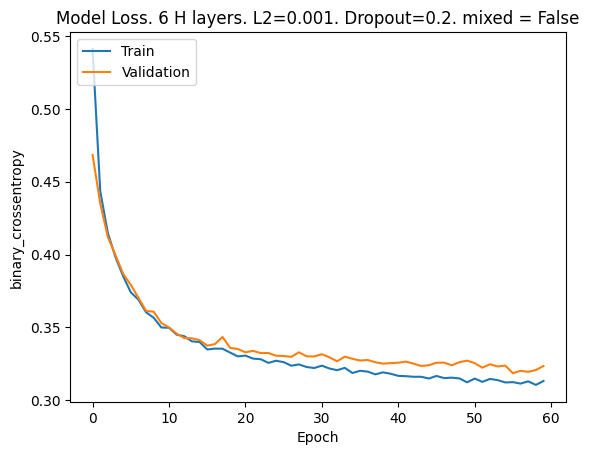

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      2103
           1       0.55      0.81      0.65       397

    accuracy                           0.86      2500
   macro avg       0.75      0.84      0.78      2500
weighted avg       0.89      0.86      0.87      2500



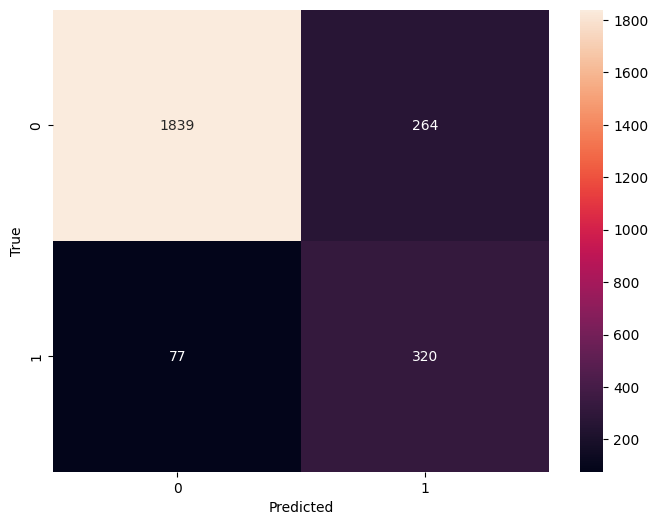

In [88]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

# Flatten the output of the hidden layer
flatten_layer = Flatten()(hidden_layer_1)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int).flatten()
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Flatten the output of the input layer
flatten_layer = Flatten()(input_layer)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_1)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

Epoch 1/60


286/286 - 10s - 34ms/step - accuracy: 0.7750 - loss: 0.5962 - val_accuracy: 0.8187 - val_loss: 0.4779
Epoch 2/60
286/286 - 1s - 4ms/step - accuracy: 0.8151 - loss: 0.4856 - val_accuracy: 0.8158 - val_loss: 0.4415
Epoch 3/60
286/286 - 1s - 5ms/step - accuracy: 0.8188 - loss: 0.4478 - val_accuracy: 0.8167 - val_loss: 0.4099
Epoch 4/60
286/286 - 1s - 4ms/step - accuracy: 0.8200 - loss: 0.4281 - val_accuracy: 0.8177 - val_loss: 0.3963
Epoch 5/60
286/286 - 1s - 4ms/step - accuracy: 0.8260 - loss: 0.4099 - val_accuracy: 0.8187 - val_loss: 0.3858
Epoch 6/60
286/286 - 1s - 4ms/step - accuracy: 0.8281 - loss: 0.3972 - val_accuracy: 0.8305 - val_loss: 0.3748
Epoch 7/60
286/286 - 1s - 4ms/step - accuracy: 0.8309 - loss: 0.3892 - val_accuracy: 0.8325 - val_loss: 0.3658
Epoch 8/60
286/286 - 1s - 4ms/step - accuracy: 0.8314 - loss: 0.3841 - val_accuracy: 0.8365 - val_loss: 0.3611
Epoch 9/60
286/286 - 1s - 4ms/step - accuracy: 0.8332 - loss: 0.3762 - val_accuracy: 0.8374 - val_loss: 0.3605
Epoch 10/6

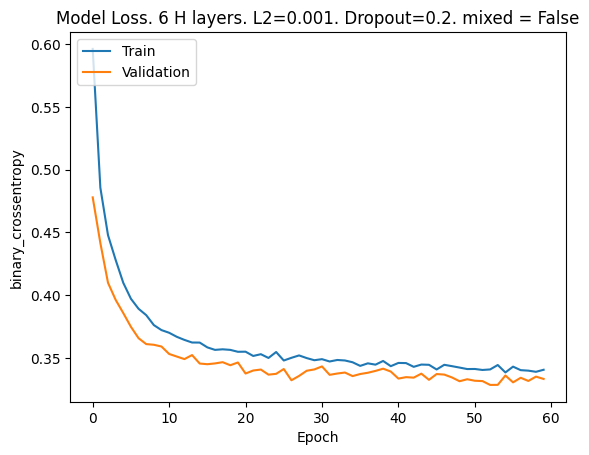

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2074
           1       0.65      0.69      0.67       426

    accuracy                           0.88      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.89      0.88      0.88      2500



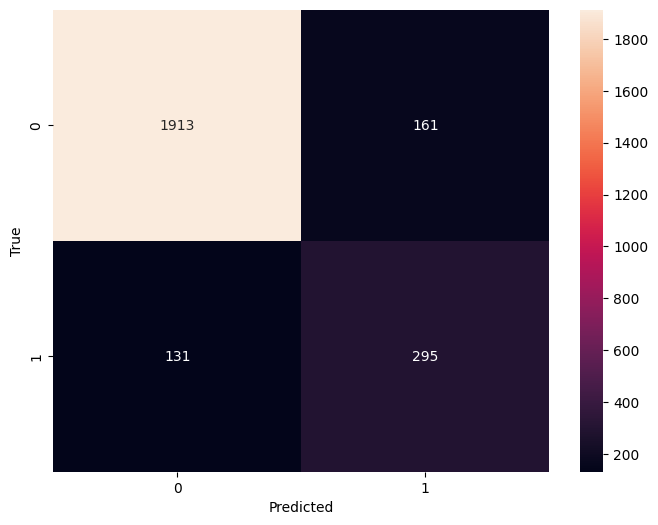

In [4]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Reshape

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Attention layer
attention = Attention()([reshaped_input, reshaped_input])

# Flatten the attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(attention)
dropout_0 = layers.Dropout(0)(flattened_attention)


# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_0)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch 1/60


286/286 - 11s - 40ms/step - accuracy: 0.7814 - loss: 0.5589 - val_accuracy: 0.8167 - val_loss: 0.4440
Epoch 2/60
286/286 - 1s - 3ms/step - accuracy: 0.8158 - loss: 0.4483 - val_accuracy: 0.8187 - val_loss: 0.4081
Epoch 3/60
286/286 - 1s - 3ms/step - accuracy: 0.8190 - loss: 0.4182 - val_accuracy: 0.8227 - val_loss: 0.3909
Epoch 4/60
286/286 - 1s - 3ms/step - accuracy: 0.8208 - loss: 0.4045 - val_accuracy: 0.8266 - val_loss: 0.3755
Epoch 5/60
286/286 - 1s - 3ms/step - accuracy: 0.8245 - loss: 0.3931 - val_accuracy: 0.8266 - val_loss: 0.3698
Epoch 6/60
286/286 - 1s - 3ms/step - accuracy: 0.8259 - loss: 0.3867 - val_accuracy: 0.8266 - val_loss: 0.3668
Epoch 7/60
286/286 - 1s - 3ms/step - accuracy: 0.8265 - loss: 0.3794 - val_accuracy: 0.8305 - val_loss: 0.3590
Epoch 8/60
286/286 - 1s - 3ms/step - accuracy: 0.8272 - loss: 0.3759 - val_accuracy: 0.8325 - val_loss: 0.3562
Epoch 9/60
286/286 - 1s - 3ms/step - accuracy: 0.8287 - loss: 0.3726 - val_accuracy: 0.8296 - val_loss: 0.3542
Epoch 10/6

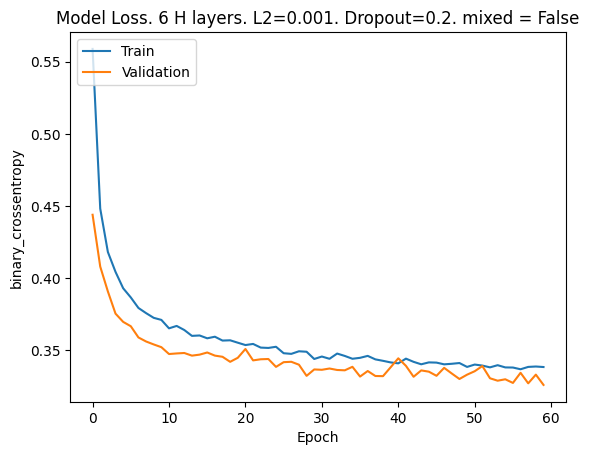

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2074
           1       0.64      0.71      0.67       426

    accuracy                           0.88      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.89      0.88      0.89      2500



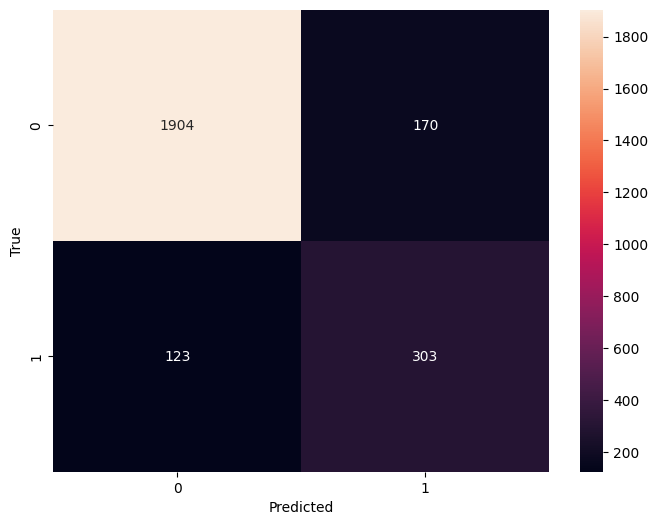

In [5]:
from keras import layers
from keras import regularizers
from keras.layers import MultiHeadAttention, Input, Reshape

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Multi-head Attention layer
multi_head_attention = MultiHeadAttention(num_heads=4, key_dim=2)(reshaped_input, reshaped_input)

# Flatten the multi-head attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(multi_head_attention)
#dropout_0 = layers.Dropout(0)(flattened_attention)

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flattened_attention)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs=60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers, models

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define your existing features_i, num_features, and other variables
num_features = len(features_i)

# Define your Transformer parameters
num_layers = 2
input_shape = (100, num_features)  # Example input shape: 100 timesteps, num_features features
embed_dim = 32
num_heads = 2
ff_dim = 32
output_dim = 1  # Output dimension, adjust as needed
rate = 0.1  # Dropout rate

# Build the Transformer-based model
def build_transformer_model(num_layers, input_shape, embed_dim, num_heads, ff_dim, output_dim, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim, rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(output_dim, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

# Build the Transformer-based model
transformer_model = build_transformer_model(num_layers, input_shape, embed_dim, num_heads, ff_dim, output_dim, rate)

# Concatenate the output of the Transformer model with additional features if needed
combined_input = layers.concatenate([transformer_model.output, ff_model.output])

# Add additional dense layers or any other layers as needed
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the final model
final_model = models.Model(inputs=[transformer_model.input, ff_model.input], outputs=outputs)

# Compile the final model
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [99]:
from tensorflow import keras
from keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # parametreleri
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # batch-layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TabTransformer(keras.Model):

    def __init__(self, 
            categories,
            num_continuous,
            dim,
            dim_out,
            depth,
            heads,
            attn_dropout,
            ff_dropout,
            mlp_hidden,
            normalize_continuous = True):
        """TabTrasformer model constructor
        Args:
            categories (:obj:`list`): list of integers denoting the number of 
                classes for a categorical feature.
            num_continuous (int): number of categorical features
            dim (int): dimension of each embedding layer output, also transformer dimension
            dim_out (int): output dimension of the model
            depth (int): number of transformers to stack
            heads (int): number of attention heads
            attn_dropout (float): dropout to use in attention layer of transformers
            ff_dropout (float): dropout to use in feed-forward layer of transformers
            mlp_hidden (:obj:`list`): list of tuples, indicating the size of the mlp layers and
                their activation functions
            normalize_continuous (boolean, optional): whether the continuous features are normalized
                before MLP layers, True by default
        """
        super(TabTransformer, self).__init__()

        # --> continuous inputs
        self.normalize_continuous = normalize_continuous
        if normalize_continuous:
            self.continuous_normalization = layers.LayerNormalization()

        # --> categorical inputs

        # embedding
        self.embedding_layers = []
        for number_of_classes in categories:
            self.embedding_layers.append(layers.Embedding(input_dim = number_of_classes, output_dim = dim))

        # concatenation
        self.embedded_concatenation = layers.Concatenate(axis=1)

        # adding transformers
        self.transformers = []
        for _ in range(depth):
            self.transformers.append(TransformerBlock(dim, heads, dim))
        self.flatten_transformer_output = layers.Flatten()

        # --> MLP
        self.pre_mlp_concatenation = layers.Concatenate()

        # mlp layers
        self.mlp_layers = []
        for size, activation in mlp_hidden:
            self.mlp_layers.append(layers.Dense(size, activation=activation))

        self.output_layer = layers.Dense(dim_out)

    def call(self, inputs):
        continuous_inputs  = inputs[0]
        categorical_inputs = inputs[1:]
        
        # --> continuous
        if self.normalize_continuous:
            continuous_inputs = self.continuous_normalization(continuous_inputs)

        # --> categorical
        #embedding_outputs = []
        # for categorical_input, embedding_layer in zip(categorical_inputs, self.embedding_layers):
        #     embedding_outputs.append(embedding_layer(categorical_input))
        # categorical_inputs = self.embedded_concatenation(embedding_outputs)
        embedding_outputs = tf.keras.layers.Lambda(lambda x: [layer(x_i) for x_i, layer in zip(x, self.embedding_layers)])(categorical_inputs)
        categorical_inputs = self.embedded_concatenation(embedding_outputs)

        for transformer in self.transformers:
            categorical_inputs = transformer(categorical_inputs)
        contextual_embedding = self.flatten_transformer_output(categorical_inputs)

        # --> MLP
        mlp_input = self.pre_mlp_concatenation([continuous_inputs, contextual_embedding])
        for mlp_layer in self.mlp_layers:
            mlp_input = mlp_layer(mlp_input)

        return self.output_layer(mlp_input)


In [100]:
from tensorflow import keras

# Define your model instance
tabTransformer = TabTransformer(
    categories=[],        # No categorical features
    num_continuous=26,    # Number of numerical features
    dim=16,               # Embedding/transformer dimension
    dim_out=1,            # Dimension of the model output (1 for binary classification)
    depth=6,              # Number of transformer layers in the stack
    heads=8,              # Number of attention heads
    attn_dropout=0.1,     # Attention layer dropout in transformers
    ff_dropout=0.1,       # Feed-forward layer dropout in transformers
    mlp_hidden=[(32, 'relu'), (16, 'relu')]  # MLP layer dimensions and activations
)


# Compile the model
tabTransformer.compile(optimizer='adam', 
              loss='mse',  # Example loss, use appropriate loss function for your task
              metrics=['mae'])  # Example metric, use appropriate metrics for your task

# Fit the model to your training data
tabTransformer.fit(training_data_classes, epochs = 150, validation_data=(X_val_noisy, y_val_label))


Epoch 1/150


OperatorNotAllowedInGraphError: Exception encountered when calling Lambda.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(None, 26), dtype=float32)
  • mask=None
  • training=None

QRNN (not working)

In [ ]:
import keras
import quantnn as q

quantiles=[0.1, 0.5, 0.9]
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, n_inputs=1, model=model)
training_data = (X_train, y_train)
# Model setup
model = qrnn(quantiles=[0.1, 0.5, 0.9], n_inputs=len(features_i))  # Estimate 10th, 50th, 90th percentiles
results = qrnn.train(training_data=training_data, n_epochs=15)

# Model fitting
model.train(X_train, y_train, epochs=100)

# Predictions
predictions = model.predict(X_test) 
print(predictions)

In [ ]:
from typhon.retrieval.qrnn.qrnn import QRNN

# 2. Create QRNN Model (Same as before)
model = QRNN(
    quantiles=[0.1, 0.5, 0.9],  
    input_dimensions=X_train.shape[1],
    model=(3, 128, 'relu'),
    initial_learning_rate = 0.01
)

training_data = (X_train, y_train)
validation_data = (X_val, y_val)

# 3. Train the Model (Updated)
model.train(training_data, validation_data, batch_size=32) 